In [1]:
# Import all the required libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score,roc_curve

In [2]:
#Load the data and inspect
df_train = pd.read_csv('Data Sets/train.csv')
df_test = pd.read_csv('Data Sets/test.csv')
print('Train',df_train.head())
print('Test',df_test.head())
print(df_train.info())

Train                                     COMMENT_ID           AUTHOR  \
0  LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU        Julius NM   
1          z13jhp0bxqncu512g22wvzkasxmvvzjaz04  ElNino Melendez   
2          z13fwbwp1oujthgqj04chlngpvzmtt3r3dw           GsMega   
3          z13lfzdo5vmdi1cm123te5uz2mqig1brz04   ferleck ferles   
4          z12avveb4xqiirsix04chxviiljryduwxg0      BeBe Burkey   

                  DATE                                            CONTENT  \
0  2013-11-07T06:20:48  Huh, anyway check out this you[tube] channel: ...   
1  2013-11-09T08:28:43   me shaking my sexy ass on my channel enjoy ^_^ ﻿   
2  2013-11-10T16:05:38            watch?v=vtaRGgvGtWQ   Check this out .﻿   
3  2013-11-27T21:39:24                          Subscribe to my channel ﻿   
4  2013-11-28T16:30:13  and u should.d check my channel and tell me wh...   

   CLASS  
0      1  
1      1  
2      1  
3      1  
4      1  
Test    ID                                   COMMENT_ID       

In [3]:
df_train['Word Count'] = df_train['CONTENT'].apply(lambda x: len(str(x).split()))
df_train['Comment Length'] = df_train['CONTENT'].apply(lambda x: len(str(x)))

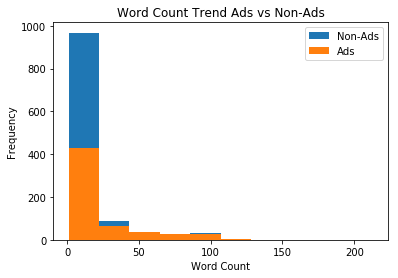

In [4]:
df_train['Word Count'].plot(kind='hist',label='Non-Ads')
df_train[df_train.CLASS==1]['Word Count'].plot(kind='hist',label='Ads')
plt.legend()
plt.xlabel('Word Count')
plt.title('Word Count Trend Ads vs Non-Ads')
plt.show()

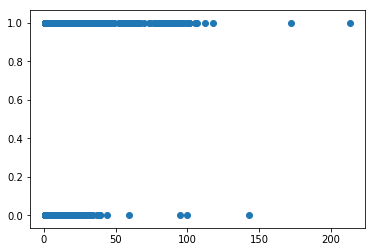

In [5]:
plt.scatter(df_train['Word Count'],df_train['CLASS'])

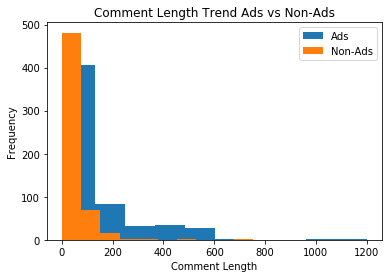

In [6]:
df_train[df_train.CLASS==1]['Comment Length'].plot(kind='hist',label='Ads',)
df_train[df_train.CLASS==0]['Comment Length'].plot(kind='hist',label='Non-Ads')
plt.xlabel('Comment Length')
plt.title('Comment Length Trend Ads vs Non-Ads')
plt.legend()
plt.show()

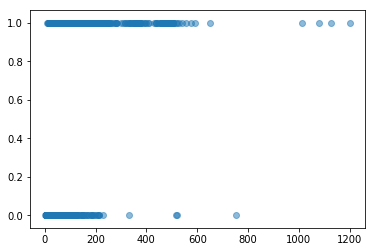

In [7]:
plt.scatter(df_train['Comment Length'],df_train['CLASS'],alpha=0.5)

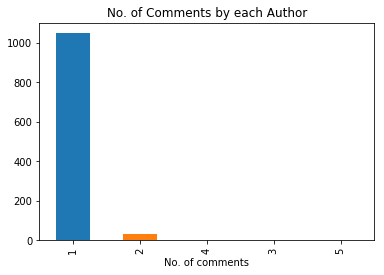

In [8]:
df_train.AUTHOR.value_counts().value_counts().plot(kind='bar')
plt.xlabel('No. of comments')
plt.title('No. of Comments by each Author')
plt.show()

In [9]:
df_train.AUTHOR.value_counts().value_counts()

1    1049
2      35
4       4
3       4
5       2
Name: AUTHOR, dtype: int64

In [10]:
df_train.describe(include='all')

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,Word Count,Comment Length
count,1157,1157,1019,1157,1157.000000,1157.000000,1157.000000
unique,1156,1094,1019,1057,NaN,NaN,NaN
top,LneaDw26bFvPh9xBHNw1btQoyP60ay_WWthtvXCx37s,M.E.S,2014-12-22T11:51:16.881000,Check out this video on YouTube:﻿,NaN,NaN,NaN
freq,2,5,1,52,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,0.506482,15.573898,94.253241
std,NaN,NaN,NaN,NaN,0.500174,22.037066,129.529575
min,NaN,NaN,NaN,NaN,0.000000,1.000000,2.000000
25%,NaN,NaN,NaN,NaN,0.000000,5.000000,30.000000
50%,NaN,NaN,NaN,NaN,1.000000,8.000000,48.000000
75%,NaN,NaN,NaN,NaN,1.000000,16.000000,97.000000


In [11]:
df_train[df_train.COMMENT_ID=='LneaDw26bFvPh9xBHNw1btQoyP60ay_WWthtvXCx37s']

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,Word Count,Comment Length
853,LneaDw26bFvPh9xBHNw1btQoyP60ay_WWthtvXCx37s,janez novak,NaN,share and like this page to win a hand signed ...,1,17,84
854,LneaDw26bFvPh9xBHNw1btQoyP60ay_WWthtvXCx37s,janez novak,NaN,share and like this page to win a hand signed ...,1,17,84


In [12]:
df_train.drop(index=853,inplace=True)
df_train.reset_index(drop=True,inplace=True)

In [13]:
df_train.COMMENT_ID.value_counts().value_counts()

1    1156
Name: COMMENT_ID, dtype: int64

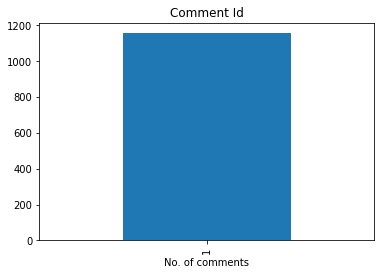

In [14]:
df_train.COMMENT_ID.value_counts().value_counts().plot(kind='bar')
plt.xlabel('No. of comments')
plt.title('Comment Id')
plt.show()

In [15]:
df_train.DATE.value_counts().value_counts()

1    1019
Name: DATE, dtype: int64

In [16]:
# The function takes the content as input and outputs all the comments stripping the numbers
def strip_num(text):
    l=WordNetLemmatizer()
    tokens=[l.lemmatize(i) for i in text.split()]
    text=" ".join(tokens)
    return " ".join(re.findall("[A-Za-z]+",text.lower()))


In [17]:
df_train.loc[:,'CONTENT']=df_train['CONTENT'].apply(strip_num)

In [18]:
# Include wordcloud module and stopwords for wordcloud
from wordcloud import WordCloud, STOPWORDS
comment_words = ''
stopwords = set(STOPWORDS)
# Generate comment words for ads
for val in df_train[df_train.CLASS==1].CONTENT: 
    # typecaste each val to string 
    val = str(val).lower() 
    # split the comments into tokens 
    tokens = val.split() 
    for word in tokens: 
        comment_words = comment_words + word + ' '

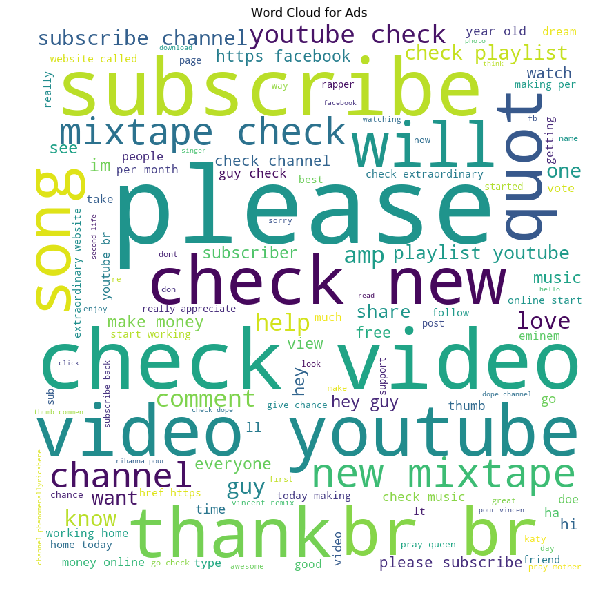

In [19]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Word Cloud for Ads')
plt.show() 

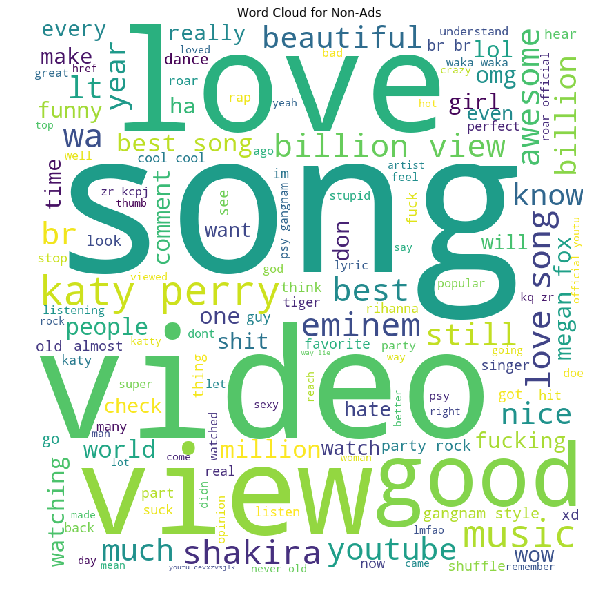

In [20]:
# Include wordcloud module and stopwords for wordcloud
from wordcloud import WordCloud, STOPWORDS
comment_words = ''
stopwords = set(STOPWORDS)
# Generate comment words for non-ads
for val in df_train[df_train.CLASS==0].CONTENT: 
    # typecaste each val to string 
    val = str(val).lower() 
    # split the comments into tokens 
    tokens = val.split() 
    for word in tokens: 
        comment_words = comment_words + word + ' '
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Word Cloud for Non-Ads')
plt.show() 

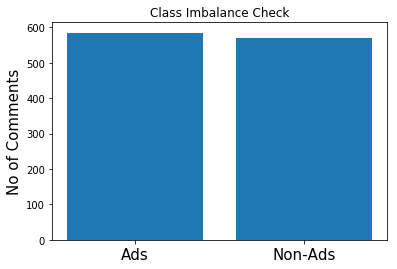

In [21]:
# Veiwing for the value counts to check for class imbalance. 
index = np.arange(len(set(df_train['CLASS'])))
plt.bar(index, df_train['CLASS'].value_counts())
plt.ylabel('No of Comments', fontsize=15)
plt.xticks(index, ['Ads','Non-Ads'], fontsize=15)
plt.title('Class Imbalance Check')
plt.show()
# No class imbalance present, so we can move forward with pre-processing the text data

In [22]:
# Feature Selection: Careful examination of the data reveals that the classification is purely based on the COMMENT
# and the CLASS. So we remove the other features.
df_train=df_train[['CONTENT','CLASS']]
df_test=df_test[['CONTENT']]

In [23]:
# Count Vectorize the data
c_vec = CountVectorizer(stop_words='english')
X_c = c_vec.fit_transform(df_train['CONTENT'])
# Using Tfidf transformer, to transform vectors
t = TfidfTransformer()
X_tfidf = t.fit_transform(X_c)
# Dividing the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf,df_train['CLASS'],test_size=0.2,random_state=112)

In [24]:
# The data has been processed, so we begin with model selection
# Using the simplest model first, LogisticRegression
model_lr = LogisticRegression(random_state=123)
model_lr.fit(X_train,y_train)
predictions = model_lr.predict(X_test)

In [25]:
# Model Evaluation using sklearn metrics
print(confusion_matrix(y_test,predictions))
print(roc_auc_score(y_test,predictions))
print(classification_report(y_test,predictions))


[[115   8]
 [ 16  93]]
0.8940851793839039
             precision    recall  f1-score   support

          0       0.88      0.93      0.91       123
          1       0.92      0.85      0.89       109

avg / total       0.90      0.90      0.90       232



In [26]:
# Generating output from test data
def pred_test(comment,c_vec,t,model):
    comment=comment.apply(strip_num)
    comment_c=c_vec.transform(comment)
    comment_tfidf=t.transform(comment_c)
    preds = model.predict(comment_tfidf)
    return preds
df_test['CLASS']=pred_test(df_test['CONTENT'],c_vec,t,model_lr)
df_test.reset_index(inplace=True)
df_test.columns=['ID','CONTENT','CLASS']
df_test.to_csv('./preds.csv',columns=['ID','CLASS'],header=True,index=False)

In [27]:
def evaluate_model(model):
    test_data=[]
    data_files = ['Youtube01-Psy.csv','Youtube02-KatyPerry.csv','Youtube03-LMFAO.csv','Youtube04-Eminem.csv','Youtube05-Shakira.csv']
    for file in data_files:
        data = pd.read_csv('./Data Sets/Test/'+file)
        test_data.append(data)
    test_data = pd.concat(test_data)
    preds=pred_test(test_data['CONTENT'],c_vec,t,model)
    # Model Evaluation using sklearn metrics
    print(confusion_matrix(test_data['CLASS'],preds))
    print(roc_auc_score(test_data['CLASS'],preds))
    print(classification_report(test_data['CLASS'],preds))
    auc=roc_auc_score(test_data['CLASS'],preds)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(test_data['CLASS'],preds)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--',label='ROC curve (area = %0.2f)' % auc)
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.legend()
    # show the plot
    plt.show()

[[925  26]
 [ 68 937]]
0.9524993329880566
             precision    recall  f1-score   support

          0       0.93      0.97      0.95       951
          1       0.97      0.93      0.95      1005

avg / total       0.95      0.95      0.95      1956



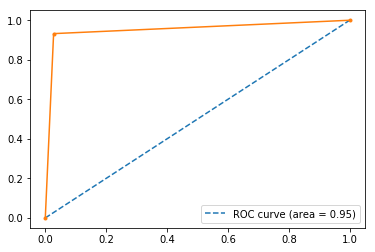

In [28]:
evaluate_model(model_lr)

In [29]:
parameters = {'penalty' : ['l1','l2'],'max_iter': [100,300,500],'random_state': [123]}
model_lr_cv = GridSearchCV(LogisticRegression(),parameters)
model_lr_cv.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'max_iter': [100, 300, 500], 'random_state': [123]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [30]:
print(model_lr_cv.best_params_)
predictions  = model_lr_cv.predict(X_train)
print(confusion_matrix(y_train,predictions))
print(roc_auc_score(y_train,predictions))
print(classification_report(y_train,predictions))
preds  = model_lr_cv.predict(X_test)
print(confusion_matrix(y_test,preds))
print(roc_auc_score(y_test,preds))
print(classification_report(y_test,preds))

{'max_iter': 100, 'penalty': 'l2', 'random_state': 123}
[[438  10]
 [ 19 457]]
0.9688813025210085
             precision    recall  f1-score   support

          0       0.96      0.98      0.97       448
          1       0.98      0.96      0.97       476

avg / total       0.97      0.97      0.97       924

[[115   8]
 [ 16  93]]
0.8940851793839039
             precision    recall  f1-score   support

          0       0.88      0.93      0.91       123
          1       0.92      0.85      0.89       109

avg / total       0.90      0.90      0.90       232



[[925  26]
 [ 68 937]]
0.9524993329880566
             precision    recall  f1-score   support

          0       0.93      0.97      0.95       951
          1       0.97      0.93      0.95      1005

avg / total       0.95      0.95      0.95      1956



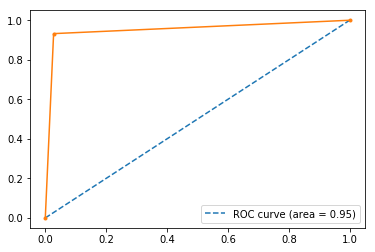

In [31]:
evaluate_model(model_lr_cv)

In [32]:
df_test['CLASS']=pred_test(df_test['CONTENT'],c_vec,t,model_lr_cv)
# df_test.reset_index(inplace=True)
df_test.columns=['ID','CONTENT','CLASS']
df_test.to_csv('./preds_cv.csv',columns=['ID','CLASS'],header=True,index=False)

In [33]:
from sklearn.ensemble import RandomForestClassifier

C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [34]:
model_rf = RandomForestClassifier(random_state=123)
model_rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [35]:
predictions = model_rf.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(roc_auc_score(y_test,predictions))
print(classification_report(y_test,predictions))

[[114   9]
 [ 15  94]]
0.8946072946968002
             precision    recall  f1-score   support

          0       0.88      0.93      0.90       123
          1       0.91      0.86      0.89       109

avg / total       0.90      0.90      0.90       232



In [36]:
df_test['CLASS']=pred_test(df_test['CONTENT'],c_vec,t,model_rf)
# df_test.reset_index(inplace=True)
df_test.columns=['ID','CONTENT','CLASS']
df_test.to_csv('./preds_rf.csv',columns=['ID','CLASS'],header=True,index=False)

[[937  14]
 [ 70 935]]
0.957813456377419
             precision    recall  f1-score   support

          0       0.93      0.99      0.96       951
          1       0.99      0.93      0.96      1005

avg / total       0.96      0.96      0.96      1956



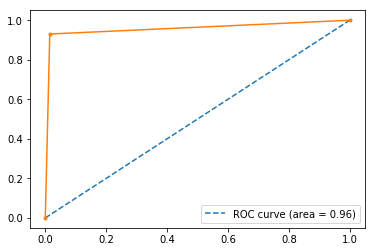

In [37]:
evaluate_model(model_rf)

In [38]:
parameters = {
                     'max_depth' : [1,3,5],
                     'n_estimators': [50,100],
                     'max_features': ['sqrt', 'auto', 'log2'],
                     'min_samples_leaf': [1, 5, 10],
                     'bootstrap': [True, False],
                     'random_state':[123]
                     }
model_rf_cv = GridSearchCV(RandomForestClassifier(),parameters)
model_rf_cv.fit(X_train,y_train)
model_rf_cv.best_params_

{'bootstrap': False,
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'n_estimators': 50,
 'random_state': 123}

[[436  12]
 [ 80 396]]
0.9025735294117648
             precision    recall  f1-score   support

          0       0.84      0.97      0.90       448
          1       0.97      0.83      0.90       476

avg / total       0.91      0.90      0.90       924

[[117   6]
 [ 20  89]]
0.8838666368315059
             precision    recall  f1-score   support

          0       0.85      0.95      0.90       123
          1       0.94      0.82      0.87       109

avg / total       0.89      0.89      0.89       232



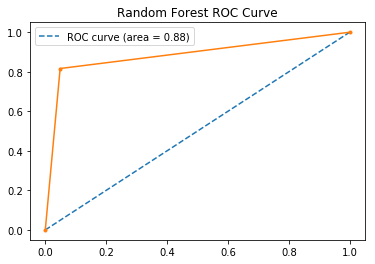

In [233]:
predictions  = model_rf_cv.predict(X_train)
print(confusion_matrix(y_train,predictions))
print(roc_auc_score(y_train,predictions))
print(classification_report(y_train,predictions))
predictions  = model_rf_cv.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(roc_auc_score(y_test,predictions))
print(classification_report(y_test,predictions))
auc=roc_auc_score(y_test,predictions)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test,predictions)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--',label='ROC curve (area = %0.2f)' % auc)
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.legend()
plt.title('Random Forest ROC Curve')
# show the plot
plt.show()

[[923  28]
 [175 830]]
0.8982139774314547
             precision    recall  f1-score   support

          0       0.84      0.97      0.90       951
          1       0.97      0.83      0.89      1005

avg / total       0.91      0.90      0.90      1956



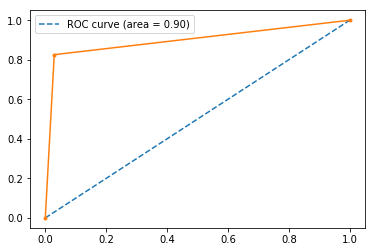

In [40]:
evaluate_model(model_rf_cv)

In [41]:
from sklearn.linear_model import SGDClassifier
model_text_svm=SGDClassifier(random_state=123)
model_text_svm.fit(X_train,y_train)

C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=123, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [42]:
predictions = model_text_svm.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(roc_auc_score(y_test,predictions))
print(classification_report(y_test,predictions))

[[115   8]
 [ 18  91]]
0.8849108674572984
             precision    recall  f1-score   support

          0       0.86      0.93      0.90       123
          1       0.92      0.83      0.88       109

avg / total       0.89      0.89      0.89       232



[[926  25]
 [ 58 947]]
0.9580002197215813
             precision    recall  f1-score   support

          0       0.94      0.97      0.96       951
          1       0.97      0.94      0.96      1005

avg / total       0.96      0.96      0.96      1956



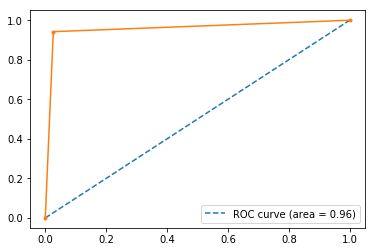

In [43]:
evaluate_model(model_text_svm)

[[115   8]
 [ 18  91]]
0.8849108674572984
             precision    recall  f1-score   support

          0       0.86      0.93      0.90       123
          1       0.92      0.83      0.88       109

avg / total       0.89      0.89      0.89       232



C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[[923  28]
 [ 46 959]]
0.9623930819090666
             precision    recall  f1-score   support

          0       0.95      0.97      0.96       951
          1       0.97      0.95      0.96      1005

avg / total       0.96      0.96      0.96      1956



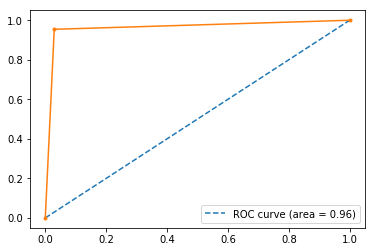

In [44]:
from sklearn.linear_model import SGDClassifier
model_svm_bp=SGDClassifier(eta0= 0.01, learning_rate='optimal', loss= 'log', penalty= 'l1',random_state=123)
model_svm_bp.fit(X_train,y_train)
predictions = model_text_svm.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(roc_auc_score(y_test,predictions))
print(classification_report(y_test,predictions))
evaluate_model(model_svm_bp)

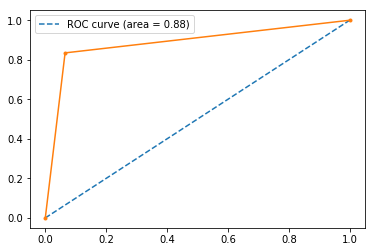

In [45]:
auc=roc_auc_score(y_test,predictions)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test,predictions)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--',label='ROC curve (area = %0.2f)' % auc)
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.legend()
# show the plot
plt.show()

In [46]:
df_test['CLASS']=pred_test(df_test['CONTENT'],c_vec,t,model_text_svm)
# df_test.reset_index(inplace=True)
df_test.columns=['ID','CONTENT','CLASS']
df_test.to_csv('./preds_svm.csv',columns=['ID','CLASS'],header=True,index=False)

In [231]:
parameters ={
             'loss' : [ 'hinge', 'log', 'modified_huber',
                        'squared_hinge', 'perceptron','squared_loss',
                        'huber', 'epsilon_insensitive',
                        'squared_epsilon_insensitive'],
             'penalty': ['l1','l2','elasticnet'],
             'learning_rate': ['optimal', 'invscaling'],
             'eta0':[0.01,0.1,0.001,0.0001],
             'random_state': [123]
            }
model_svm_cv = GridSearchCV(SGDClassifier(),parameters)
model_svm_cv.fit(X_train,y_train)

C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\sit

C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\sit

C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\sit

C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\sit

C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\sit

C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\sit

C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\sit

C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\sit

C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\sit

C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\sit

C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\sit

C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\sit

C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\sit

C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\sit

C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\sit

C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\sit

C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\ytnvj\Anaconda3\lib\sit

GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'], 'penalty': ['l1', 'l2', 'elasticnet'], 'learning_rate': ['optimal', 'invscaling'], 'eta0': [0.01, 0.1, 0.001, 0.0001], 'random_state': [123]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

{'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'hinge', 'penalty': 'l2', 'random_state': 123}
[[448   0]
 [  3 473]]
0.9968487394957983
             precision    recall  f1-score   support

          0       0.99      1.00      1.00       448
          1       1.00      0.99      1.00       476

avg / total       1.00      1.00      1.00       924

[[115   8]
 [ 18  91]]
0.8849108674572984
             precision    recall  f1-score   support

          0       0.86      0.93      0.90       123
          1       0.92      0.83      0.88       109

avg / total       0.89      0.89      0.89       232



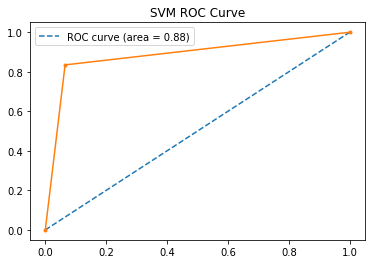

In [232]:
print(model_svm_cv.best_params_)
predictions  = model_svm_cv.predict(X_train)
print(confusion_matrix(y_train,predictions))
print(roc_auc_score(y_train,predictions))
print(classification_report(y_train,predictions))
predictions  = model_svm_cv.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(roc_auc_score(y_test,predictions))
print(classification_report(y_test,predictions))
auc=roc_auc_score(y_test,predictions)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test,predictions)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--',label='ROC curve (area = %0.2f)' % auc)
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.legend()
plt.title('SVM ROC Curve')
# show the plot
plt.show()

[[926  25]
 [ 58 947]]
0.9580002197215813
             precision    recall  f1-score   support

          0       0.94      0.97      0.96       951
          1       0.97      0.94      0.96      1005

avg / total       0.96      0.96      0.96      1956



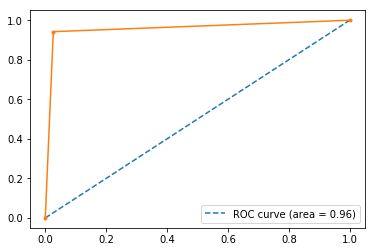

In [49]:
evaluate_model(model_svm_cv)

In [50]:
df_test['CLASS']=pred_test(df_test['CONTENT'],c_vec,t,model_svm_cv)
# df_test.reset_index(inplace=True)
df_test.columns=['ID','CONTENT','CLASS']
df_test.to_csv('./preds_svm_cv.csv',columns=['ID','CLASS'],header=True,index=False)

In [51]:
from sklearn.neighbors import KNeighborsClassifier
model_knn=KNeighborsClassifier()
model_knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [52]:
predictions = model_knn.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(roc_auc_score(y_test,predictions))
print(classification_report(y_test,predictions))

[[113  10]
 [ 28  81]]
0.8309092265234579
             precision    recall  f1-score   support

          0       0.80      0.92      0.86       123
          1       0.89      0.74      0.81       109

avg / total       0.84      0.84      0.83       232



[[903  48]
 [236 769]]
0.85735047161668
             precision    recall  f1-score   support

          0       0.79      0.95      0.86       951
          1       0.94      0.77      0.84      1005

avg / total       0.87      0.85      0.85      1956



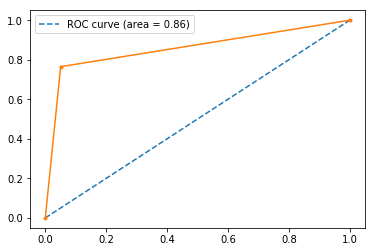

In [53]:
evaluate_model(model_knn)

In [54]:
parameters ={
             'n_neighbors' : [3,5,7,9,11],
             'p': [1,2],
            }
model_knn_cv = GridSearchCV(KNeighborsClassifier(),parameters)
model_knn_cv.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 5, 7, 9, 11], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

[[108  15]
 [ 28  81]]
0.8105840232714253
             precision    recall  f1-score   support

          0       0.79      0.88      0.83       123
          1       0.84      0.74      0.79       109

avg / total       0.82      0.81      0.81       232



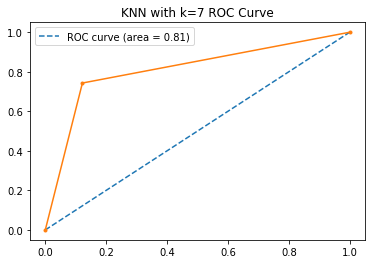

In [228]:
predictions = model_knn_cv.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(roc_auc_score(y_test,predictions))
print(classification_report(y_test,predictions))
auc=roc_auc_score(y_test,predictions)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test,predictions)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--',label='ROC curve (area = %0.2f)' % auc)
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.legend()
plt.title('KNN with k=7 ROC Curve')
# show the plot
plt.show()

In [56]:
model_knn_cv.best_params_


{'n_neighbors': 7, 'p': 2}

In [57]:
from sklearn.svm import SVC

In [58]:
model_svc=SVC(random_state=123)

In [59]:
model_svc.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=123, shrinking=True,
  tol=0.001, verbose=False)

In [60]:
predictions = model_svc.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(roc_auc_score(y_test,predictions))
print(classification_report(y_test,predictions))

[[  0 123]
 [  0 109]]
0.5
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       123
          1       0.47      1.00      0.64       109

avg / total       0.22      0.47      0.30       232



C:\Users\ytnvj\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


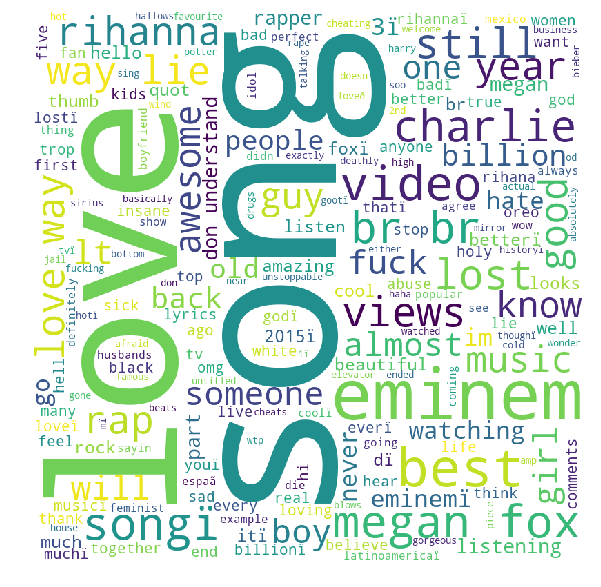

In [61]:
# Python program to generate WordCloud 
  
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt 
import pandas as pd 
  
# Reads 'Youtube04-Eminem.csv' file  
df = pd.read_csv(r"./Data Sets/Test/Youtube04-Eminem.csv", encoding ="latin-1") 
  
comment_words = ''
stopwords = set(STOPWORDS) 

# iterate through the csv file 
for val in df[df.CLASS==0].CONTENT: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

[[438  10]
 [ 19 457]]
0.9688813025210085
             precision    recall  f1-score   support

          0       0.96      0.98      0.97       448
          1       0.98      0.96      0.97       476

avg / total       0.97      0.97      0.97       924

[[115   8]
 [ 16  93]]
0.8940851793839039
             precision    recall  f1-score   support

          0       0.88      0.93      0.91       123
          1       0.92      0.85      0.89       109

avg / total       0.90      0.90      0.90       232



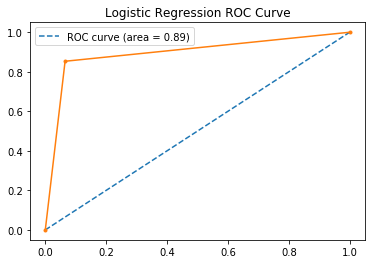

In [226]:
model_lr_bp=LogisticRegression(max_iter=100,penalty='l2',random_state=123)
# The data has been processed, so we begin with model selection
# Using the simplest model first, LogisticRegression
model_lr_bp.fit(X_train,y_train)
predictions = model_lr_bp.predict(X_test)

# Model Evaluation using sklearn metrics
print(confusion_matrix(y_train,model_lr_bp.predict(X_train)))
print(roc_auc_score(y_train,model_lr_bp.predict(X_train)))
print(classification_report(y_train,model_lr_bp.predict(X_train)))
print(confusion_matrix(y_test,predictions))
print(roc_auc_score(y_test,predictions))
print(classification_report(y_test,predictions))
auc=roc_auc_score(y_test,predictions)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test,predictions)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--',label='ROC curve (area = %0.2f)' % auc)
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.legend()
plt.title('Logistic Regression ROC Curve')
# show the plot
plt.show()

In [63]:
len(c_vec.get_feature_names())

2719

In [184]:
wc=pd.DataFrame(X_c.toarray().sum(axis=0).reshape(-1,1),columns=['Count'],index=c_vec.get_feature_names())

In [189]:
wc['Weights']=model_lr_bp.coef_[0]
wc['Exp(Weights)']=wc.Weights.apply(np.exp)

In [190]:
wc=wc.sort_values(by='Exp(Weights)')

In [193]:
wc.head(10)

,Count,Weights,Exp(Weights)
song,184,-1.947822,0.142584
love,99,-1.888717,0.151266
billion,35,-1.619838,0.197931
view,40,-1.484160,0.226693
views,41,-1.361632,0.256242
good,46,-1.288915,0.275570
best,48,-1.233995,0.291127
perry,41,-1.107928,0.330242
shakira,25,-1.080616,0.339386
wow,13,-1.022317,0.359761


In [224]:
print(wc.tail(10))
print(f'\n                 Table2')


            Count   Weights  Exp(Weights)
facebook       48  1.402649      4.065956
http           79  1.614016      5.022941
subscriber     19  1.625273      5.079808
share          33  1.860286      6.425577
https          70  1.875135      6.521701
www            82  1.944620      6.990975
channel       107  2.681780     14.611079
com           181  3.505053     33.283205
subscribe     127  4.053339     57.589406
check         341  4.776054    118.635288

                 Table2


In [219]:
def pred_one(text,c_vec,t,model):
    comment=strip_num(text)
    comment_c=c_vec.transform([comment])
    comment_tfidf=t.transform(comment_c)
    pred = model.predict(comment_tfidf)
    return pred

In [223]:
pred_one('Hi, love the song. Please subsribe to my channel at http//youtube.com',c_vec,t,model_lr_bp)

array([1], dtype=int64)

In [68]:
from sklearn.naive_bayes import MultinomialNB

In [69]:
nb=MultinomialNB()

In [70]:
nb.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [71]:
nb.score(X_test,y_test)

0.8836206896551724

In [72]:
nb.score(X_train,y_train)

0.9642857142857143

[[864  87]
 [ 56 949]]
0.9263979785614515
             precision    recall  f1-score   support

          0       0.94      0.91      0.92       951
          1       0.92      0.94      0.93      1005

avg / total       0.93      0.93      0.93      1956



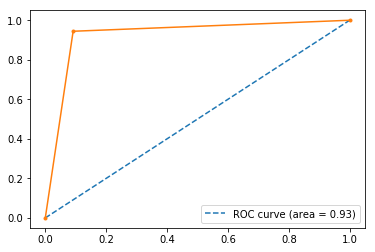

In [73]:
evaluate_model(nb)

In [74]:
from sklearn.neural_network import MLPClassifier

In [82]:
mlp=MLPClassifier(hidden_layer_sizes=(100,200,300,),activation='tanh')

In [83]:
mlp.fit(X_train,y_train)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 200, 300), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [84]:
mlp.score(X_test,y_test)

0.8448275862068966

[[882  69]
 [ 46 959]]
0.9408368253370372
             precision    recall  f1-score   support

          0       0.95      0.93      0.94       951
          1       0.93      0.95      0.94      1005

avg / total       0.94      0.94      0.94      1956



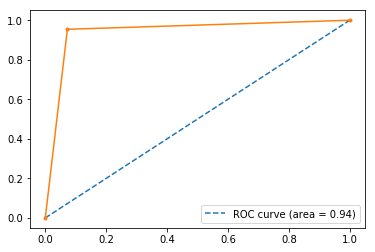

In [85]:
evaluate_model(mlp)

In [137]:
y_p=df_train['CLASS'].values

In [138]:
np.random.randn(X_p_train.shape[1])

array([ 1.76992606, -0.43154452, -0.87108295, ...,  2.03944488,
       -1.45426429,  0.57293277])

In [139]:
y_p=np.where(y_p==0,-1,1)

In [140]:
y_p

array([ 1,  1,  1, ..., -1, -1, -1])

In [169]:
X_p_train, X_p_test, y_p_train, y_p_test = train_test_split(X_tfidf.toarray(),y_p,test_size=0.2,random_state=112)

In [170]:
class Perceptron(object):
    def fit(self,X,y,lr=1.0,epochs=1000):
        D=X.shape[1]
        self.w=np.random.randn(D)
        self.b=0
        N=len(y)
        costs=[]
        for e in range(epochs):
            y_pred=self.predict(X)
            mc_x=np.nonzero(y!=y_pred)[0]
            if len(mc_x)==0:
                break
            self.w += lr*(y[mc_x]).dot(X[mc_x])
            self.b += lr*(y[mc_x]).sum()
            c= len(mc_x)/float(N)
            costs.append(c)
            print("final w:", self.w, "final b:", self.b,"cost: ",c, "epochs:", (e+1), "/", epochs)
        plt.plot(costs)
        plt.show()
    def predict(self, X):
        return np.sign(X.dot(self.w) + self.b)

    def score(self, X, Y):
        P = self.predict(X)
        return np.mean(P == Y)

In [171]:
p=Perceptron()

final w: [-0.98422806  0.5957751   0.07095639 ...  1.87425792  3.13168856
  0.97154505] final b: -37.0 cost:  0.4945887445887446 epochs: 1 / 1000
final w: [-0.36783301  1.14688643  0.39285208 ...  1.87425792  6.02954884
  1.06675879] final b: 439.0 cost:  0.5151515151515151 epochs: 2 / 1000
final w: [-0.36783301  1.14688643  0.39285208 ...  1.87425792  6.02954884
 -0.06825064] final b: -9.0 cost:  0.48484848484848486 epochs: 3 / 1000
final w: [-0.36783301  1.14688643  0.39285208 ...  1.87425792  6.02954884
 -0.85102463] final b: 81.0 cost:  0.12987012987012986 epochs: 4 / 1000
final w: [-0.36783301  1.14688643  0.39285208 ...  1.87425792  6.02954884
 -1.98603406] final b: -367.0 cost:  0.48484848484848486 epochs: 5 / 1000
final w: [ 0.24856205  1.69799777  0.71474777 ...  1.87425792  8.92740913
 -1.89082032] final b: 109.0 cost:  0.5151515151515151 epochs: 6 / 1000
final w: [ 0.24856205  1.69799777  0.71474777 ...  1.87425792  8.92740913
 -3.02582975] final b: -339.0 cost:  0.484848484

final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -82.54150185] final b: -22.0 cost:  0.012987012987012988 epochs: 121 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -83.32427584] final b: -27.0 cost:  0.01406926406926407 epochs: 122 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -83.32427584] final b: -19.0 cost:  0.017316017316017316 epochs: 123 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -84.10704984] final b: -26.0 cost:  0.016233766233766232 epochs: 124 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -84.10704984] final b: -23.0 cost:  0.011904761904761904 epochs: 125 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -84.10704984] final b: -25.0 cost:  0.010822510822510822 epochs: 126 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792

final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -91.32370312] final b: -23.0 cost:  0.0183982683982684 epochs: 227 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -91.32370312] final b: -11.0 cost:  0.012987012987012988 epochs: 228 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -91.32370312] final b: -9.0 cost:  0.0021645021645021645 epochs: 229 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -91.32370312] final b: -10.0 cost:  0.003246753246753247 epochs: 230 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -91.32370312] final b: -10.0 cost:  0.0021645021645021645 epochs: 231 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -91.32370312] final b: -8.0 cost:  0.0021645021645021645 epochs: 232 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792

final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -93.72925421] final b: -3.0 cost:  0.0021645021645021645 epochs: 319 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -93.72925421] final b: -3.0 cost:  0.0021645021645021645 epochs: 320 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -93.72925421] final b: -3.0 cost:  0.0021645021645021645 epochs: 321 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -93.72925421] final b: -3.0 cost:  0.0021645021645021645 epochs: 322 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -93.72925421] final b: -1.0 cost:  0.0021645021645021645 epochs: 323 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.13017939] final b: -21.0 cost:  0.023809523809523808 epochs: 324 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.8742579

final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: -2.0 cost:  0.004329004329004329 epochs: 408 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: 0.0 cost:  0.0021645021645021645 epochs: 409 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: -2.0 cost:  0.004329004329004329 epochs: 410 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: 0.0 cost:  0.0021645021645021645 epochs: 411 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: -2.0 cost:  0.004329004329004329 epochs: 412 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: 0.0 cost:  0.0021645021645021645 epochs: 413 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.

 -94.93202976] final b: 0.0 cost:  0.0021645021645021645 epochs: 505 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: -2.0 cost:  0.004329004329004329 epochs: 506 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: 0.0 cost:  0.0021645021645021645 epochs: 507 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: -2.0 cost:  0.004329004329004329 epochs: 508 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: 0.0 cost:  0.0021645021645021645 epochs: 509 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: -2.0 cost:  0.004329004329004329 epochs: 510 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: 0.0 cost:  0.0021645021645021645 epochs: 511 /

final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: -2.0 cost:  0.004329004329004329 epochs: 604 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: 0.0 cost:  0.0021645021645021645 epochs: 605 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: -2.0 cost:  0.004329004329004329 epochs: 606 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: 0.0 cost:  0.0021645021645021645 epochs: 607 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: -2.0 cost:  0.004329004329004329 epochs: 608 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: 0.0 cost:  0.0021645021645021645 epochs: 609 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.

final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: 0.0 cost:  0.0021645021645021645 epochs: 703 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: -2.0 cost:  0.004329004329004329 epochs: 704 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: 0.0 cost:  0.0021645021645021645 epochs: 705 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: -2.0 cost:  0.004329004329004329 epochs: 706 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: 0.0 cost:  0.0021645021645021645 epochs: 707 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: -2.0 cost:  0.004329004329004329 epochs: 708 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.

final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: -2.0 cost:  0.004329004329004329 epochs: 800 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: 0.0 cost:  0.0021645021645021645 epochs: 801 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: -2.0 cost:  0.004329004329004329 epochs: 802 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: 0.0 cost:  0.0021645021645021645 epochs: 803 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: -2.0 cost:  0.004329004329004329 epochs: 804 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: 0.0 cost:  0.0021645021645021645 epochs: 805 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.

final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: -2.0 cost:  0.004329004329004329 epochs: 888 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: 0.0 cost:  0.0021645021645021645 epochs: 889 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: -2.0 cost:  0.004329004329004329 epochs: 890 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: 0.0 cost:  0.0021645021645021645 epochs: 891 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: -2.0 cost:  0.004329004329004329 epochs: 892 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: 0.0 cost:  0.0021645021645021645 epochs: 893 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.

final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: -2.0 cost:  0.004329004329004329 epochs: 984 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: 0.0 cost:  0.0021645021645021645 epochs: 985 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: -2.0 cost:  0.004329004329004329 epochs: 986 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: 0.0 cost:  0.0021645021645021645 epochs: 987 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: -2.0 cost:  0.004329004329004329 epochs: 988 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.66160155
 -94.93202976] final b: 0.0 cost:  0.0021645021645021645 epochs: 989 / 1000
final w: [  9.43939085  10.51577909   6.18697454 ...   1.87425792  43.

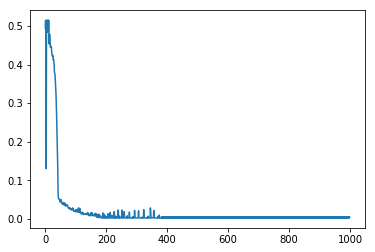

In [172]:
p.fit(X_p_train,y_p_train)

In [173]:
X_p_train[916]

array([0., 0., 0., ..., 0., 0., 0.])

In [174]:
p.score(X_p_test,y_p_test)

0.8922413793103449

In [175]:
p.score(X_p_train,y_p_train)

0.9978354978354979

In [176]:
def evaluate_perceptron(model):
    test_data=[]
    data_files = ['Youtube01-Psy.csv','Youtube02-KatyPerry.csv','Youtube03-LMFAO.csv','Youtube04-Eminem.csv','Youtube05-Shakira.csv']
    for file in data_files:
        data = pd.read_csv('./Data Sets/Test/'+file)
        test_data.append(data)
    test_data = pd.concat(test_data)
    comment=test_data['CONTENT'].apply(strip_num)
    comment_c=c_vec.transform(comment)
    comment_tfidf=t.transform(comment_c)
    preds = model.predict(comment_tfidf.toarray())
    y=test_data['CLASS'].values
    y=np.where(y==0,-1,1)
    # Model Evaluation using sklearn metrics
    print(confusion_matrix(y,preds))
    print(roc_auc_score(y,preds))
    print(classification_report(y,preds))
    auc=roc_auc_score(y,preds)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y,preds)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--',label='ROC curve (area = %0.2f)' % auc)
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.legend()
    # show the plot
    plt.show()

[[888  63]
 [ 28 977]]
0.9529466233501263
             precision    recall  f1-score   support

         -1       0.97      0.93      0.95       951
          1       0.94      0.97      0.96      1005

avg / total       0.95      0.95      0.95      1956



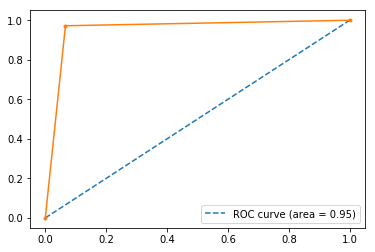

In [177]:
evaluate_perceptron(p)

In [235]:
# Generate Word Cloud from text for Ads by default
def generate_wordcloud(df,c=1):
    comment_words = ''
    stopwords = set(STOPWORDS)
    # Generate comment words for non-ads
    for val in df[df.CLASS==c].CONTENT: 
        # typecaste each val to string 
        val = str(val).lower() 
        # split the comments into tokens 
        tokens = val.split() 
        for word in tokens: 
            comment_words = comment_words + word + ' '
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title('Word Cloud for Non-Ads')
    plt.show() 

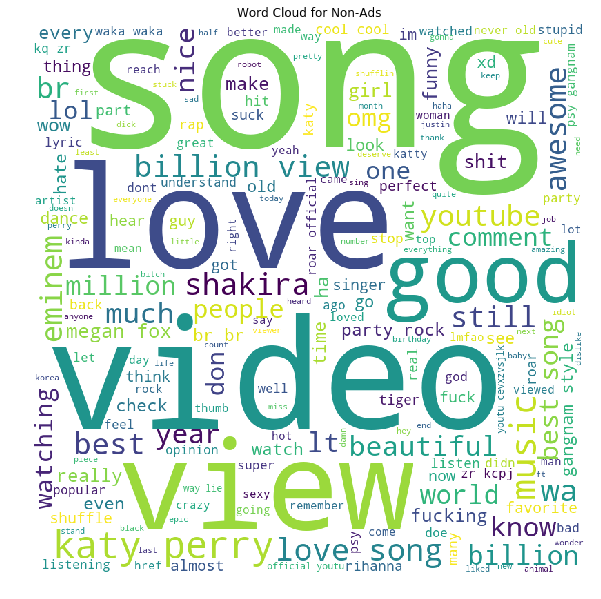

In [237]:
generate_wordcloud(df_train,0)

In [240]:
model_svm_bp.coef_

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -5.25669153]])